In [1]:
!pip install BorutaShap

## Introduction

Football is the most popular sport around the world. It is a team sport played with a spherical ball between two teams of 11 players. The game is played on a rectangular field called a pitch with a goal at each end. The objective of the game is to score more goals than the opposition by moving the ball beyond the goal line into the opposing goal, usually within a time frame of 90 or more minutes. 

## Metrics for the project

The goal of the competition is to predict the probabilities for each of the target classes - home, away and draw. The metrics for evaluation for the project is the multinomial log loss which measures the quality of the predicted probabilities. 

## Preparing the environment

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
train = pd.read_csv('../input/football-match-probability-prediction/train.csv')
test = pd.read_csv('../input/football-match-probability-prediction/test.csv')
target_scores = pd.read_csv('../input/football-match-probability-prediction/train_target_and_scores.csv')

train.shape, test.shape

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


((110938, 190), (72711, 189))

## Exploratory Data Analysis

In [4]:
train.head()

,id,target,home_team_name,away_team_name,match_date,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,...,away_team_history_league_id_1,away_team_history_league_id_2,away_team_history_league_id_3,away_team_history_league_id_4,away_team_history_league_id_5,away_team_history_league_id_6,away_team_history_league_id_7,away_team_history_league_id_8,away_team_history_league_id_9,away_team_history_league_id_10
0,11906497,away,Newell's Old Boys,River Plate,2019-12-01 00:45:00,Superliga,636,False,468196.0,468200.0,...,1122.0,642.0,636.0,636.0,636.0,1122.0,636.0,642.0,636.0,1122.0
1,11984383,home,Real Estelí,Deportivo Las Sabanas,2019-12-01 01:00:00,Primera Division,752,False,516788.0,22169161.0,...,752.0,752.0,752.0,752.0,752.0,752.0,752.0,752.0,752.0,752.0
2,11983301,draw,UPNFM,Marathón,2019-12-01 01:00:00,Liga Nacional,734,False,2510608.0,456313.0,...,734.0,734.0,734.0,734.0,734.0,734.0,734.0,734.0,734.0,734.0
3,11983471,away,León,Morelia,2019-12-01 01:00:00,Liga MX,743,False,1552508.0,465797.0,...,743.0,743.0,743.0,743.0,743.0,743.0,743.0,743.0,746.0,743.0
4,11883005,home,Cobán Imperial,Iztapa,2019-12-01 01:00:00,Liga Nacional,705,False,429958.0,426870.0,...,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0,705.0


Let's see the distribution of the target we're trying to predict

In [5]:
train['target'].value_counts()

home    48113
away    35174
draw    27651
Name: target, dtype: int64

[Text(0.5, 0, 'Target'), Text(0, 0.5, 'Density')]

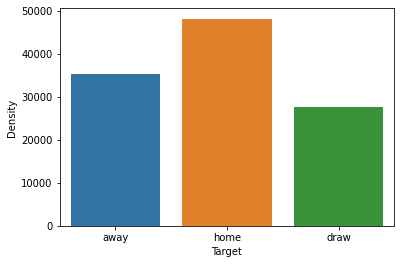

In [6]:
sns.countplot(x='target', data=train).set(xlabel='Target', ylabel='Density')

As we see from above, we have three target values - away, home and draw. home team means the home team won, away means the away team won and draw means they had a tie in the game. 

Let's see the kind of league games this dataset contains

In [7]:
train['league_name'].value_counts()

Premier League         5565
Club Friendlies        3724
Primera Division       2369
Super League           1530
3. Liga                1327
                       ... 
Play-offs 2/3             1
Trofeo Joan Gamper        1
4. Liga Division F        1
Copa Paraguay             1
National 3: Group L       1
Name: league_name, Length: 727, dtype: int64

Majority of the matches are from Premier League, Club Friendlies and Primera Division

### Functions to help with EDA

Let's write some functions to help with the process of exploratory data analysis

In [8]:
def missing_values_table(df):
    """Returns a dataframe of number of missing entries per column in df"""
    miss_val = df.isnull().sum()
    miss_val_percent = (100 * df.isnull().sum())/len(df)
    miss_val_table = pd.concat([miss_val, miss_val_percent], axis=1)
    miss_val_table = miss_val_table.rename(columns={0: 'Missing values', 1: 'Percent of missing values'})
    
    # sort by percent of missing values for only cols with missing values
    miss_val_table = miss_val_table[miss_val_table.iloc[:, 1] != 0].sort_values(by='Percent of missing values', ascending=False).round(1)
    print(f'The dataframe has {str(df.shape[1])} columns.\nThere are {str(miss_val_table.shape[0])} columns with missing values')
    return miss_val_table

In [9]:
def numeric_distribution_plot(df):
    """Plots a seaborn displot for all numeric features in the dataset"""
    num_features = df.select_dtypes(exclude='object').columns # only include numeric features
    print(f"There are {len(num_features)} numeric features in the dataset")
    for feature in num_features[:20]: # restrics the plot to only 20 cols
        plt.figure(figsize=(12, 5))
        sns.displot(data=df, x=feature)
        plt.show()

def categorical_feature_plot(df):
    """Plots a countplot for all categorical features present in the dataframe"""
    cat_features = df.select_dtypes(include='object').columns
    print(f"There are {len(cat_features)} categorical columns in df")
    for feature in cat_features:
        plt.figure(figsize=(12,5))
        sns.countplot(x = feature, data=df)
        plt.tight_layout()
        plt.show()

In [10]:
missing_values_table(train)[:20]

The dataframe has 190 columns.
There are 186 columns with missing values


,Missing values,Percent of missing values
away_team_history_coach_10,27129,24.5
home_team_history_coach_10,26653,24.0
away_team_history_coach_9,26150,23.6
home_team_history_coach_9,25733,23.2
away_team_history_coach_8,25219,22.7
home_team_history_coach_8,24869,22.4
away_team_history_coach_7,24377,22.0
home_team_history_coach_7,23980,21.6
away_team_history_coach_6,23525,21.2
home_team_history_coach_6,23258,21.0


Reading from the documentation of the dataset, we have two types of features in the train dataset - descriptive features and historical features. The descriptive features are point-in-time descriptions of the match that has to be predicted. Historical features contain past information of the 10 games previously played by the Home and the Away team. The historical features contain the keyword ```history``` in them. 

In the dataframe above for the missing values, we see that most of these features are historical features. Let's see a few of them

In [11]:
temp = train[['away_team_history_coach_10', 'home_team_history_coach_10', 'away_team_history_coach_9', 'home_team_history_coach_9']]
temp.head()

,away_team_history_coach_10,home_team_history_coach_10,away_team_history_coach_9,home_team_history_coach_9
0,468200.0,468196.0,468200.0,468196.0
1,22169161.0,516788.0,22169161.0,516788.0
2,456313.0,2510608.0,456313.0,2510608.0
3,465797.0,1552508.0,465797.0,1552508.0
4,37261558.0,429958.0,37261558.0,429958.0


The features above refer to the coach id of the home & away teams respectively in the 10th and 9th teams.
Other descriptions of the historical data present in the dataset...

* ```home_team_history_match_date_{i}``` - date of the last ith match played by home
* ```home_team_history_is_play_home_{i}``` - if 1, the home team played home
* ```home_team_history_is_cup_{i}``` - If 1, the match was a cup competition.
* ```home_team_history_goal_{i}``` - The number of goals scored by the Home team on its last i-th match.
* ```home_team_history_opponent_goal_{i}``` - The number of goals conceded by the Home team on its last i-th match.
* ```home_team_history_rating_{i}``` - The rating of the Home team on its last i-th match (pre match rating).
* ```home_team_history_opponent_rating_{i}``` - The rating of the opponent team on Home team last i-th match (pre match rating).
* ```home_team_history_coach_{i}``` - The coach id of the Home team on its last i-th match.
* ```home_team_history_league_id_{i}``` - The league name id by the Home team on its last i-th match.

The feature definitions refer to the away team if the prefix home is replaced with away. 

For each of the 9 features above, we have 9 more for the away teams and each of the features are available for the 10 matches in the dataset. Based on this, we're expecting to have 18 x 10 = 180 historical features.

From the competition documentation on the ratings: 'ratings are calculated by Octosport and correspond to the pre-match team's relative strength. It is provided for all 10 historical matches. But, we do not provide the team's rating for the match you have to predict. The reason being these ratings will already contain the winning probabilities information'.

Let's see some of these features to gain a concrete idea of what they mean... Let i = 1, the most recent match
 

In [12]:
temp = train[['home_team_name', 'away_team_name', 'home_team_history_match_date_1', 'away_team_history_match_date_1', 'home_team_history_is_play_home_1',
              'home_team_history_is_cup_1', 'home_team_history_goal_1', 'home_team_history_opponent_goal_1', 'home_team_history_rating_1', 'home_team_history_opponent_rating_1',
             'home_team_history_coach_1', 'home_team_history_league_id_1']]
temp.head()

,home_team_name,away_team_name,home_team_history_match_date_1,away_team_history_match_date_1,home_team_history_is_play_home_1,home_team_history_is_cup_1,home_team_history_goal_1,home_team_history_opponent_goal_1,home_team_history_rating_1,home_team_history_opponent_rating_1,home_team_history_coach_1,home_team_history_league_id_1
0,Newell's Old Boys,River Plate,2019-11-26 00:10:00,2019-11-23 20:00:00,0.0,0.0,0.0,1.0,3.856860,5.199840,468196.0,636.0
1,Real Estelí,Deportivo Las Sabanas,2019-11-27 21:00:00,2019-11-27 21:00:00,1.0,0.0,0.0,2.0,13.668800,3.671610,516788.0,752.0
2,UPNFM,Marathón,2019-11-28 01:15:00,2019-11-21 01:30:00,0.0,0.0,3.0,1.0,5.736719,6.825194,2510608.0,734.0
3,León,Morelia,2019-11-28 01:00:00,2019-11-28 01:00:00,0.0,0.0,3.0,3.0,5.998800,5.998800,1552508.0,743.0
4,Cobán Imperial,Iztapa,2019-11-27 18:00:00,2019-11-27 19:00:00,0.0,0.0,1.0,2.0,6.295743,5.535514,429958.0,705.0


In [13]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110938 entries, 0 to 110937
Data columns (total 12 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   home_team_name                       110937 non-null  object 
 1   away_team_name                       110937 non-null  object 
 2   home_team_history_match_date_1       109779 non-null  object 
 3   away_team_history_match_date_1       109712 non-null  object 
 4   home_team_history_is_play_home_1     109779 non-null  float64
 5   home_team_history_is_cup_1           109725 non-null  float64
 6   home_team_history_goal_1             109779 non-null  float64
 7   home_team_history_opponent_goal_1    109779 non-null  float64
 8   home_team_history_rating_1           109767 non-null  float64
 9   home_team_history_opponent_rating_1  109767 non-null  float64
 10  home_team_history_coach_1            89415 non-null   float64
 11  home_team_his

From this we can see that the date columns in the dataframe are in type object, we'll need to convert them to datetime type for future work.

For now, let's look at the descriptive features. They should be 10

* ```id``` - the id of the game
* ```target``` - The variable you have to predict the probabilities only available in the train set.
* ```home_team_name``` - The name of the Home the team. Hidden in test set, see this discussion
* ```away_team_name``` - The name of the Away the team. Hidden in test set, see this discussion
* ```match_date``` - The match date (UTC).
* ```league_name``` - The league name.
* ```league_id``` - The league id. Note that league names can be identical for two differents id.
* ```is_cup``` - If the value is 1 the match is played for a cup compettion.
* ```home_team_coach_id``` - The id of the Home team coach.
* ```away_team_coach_id``` - The id of the Away team coach.


In [14]:
temp = train[['id', 'target', 'home_team_name', 'away_team_name', 'match_date', 'league_name', 'league_id', 
             'is_cup', 'home_team_coach_id', 'away_team_coach_id']]
temp.head()

,id,target,home_team_name,away_team_name,match_date,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id
0,11906497,away,Newell's Old Boys,River Plate,2019-12-01 00:45:00,Superliga,636,False,468196.0,468200.0
1,11984383,home,Real Estelí,Deportivo Las Sabanas,2019-12-01 01:00:00,Primera Division,752,False,516788.0,22169161.0
2,11983301,draw,UPNFM,Marathón,2019-12-01 01:00:00,Liga Nacional,734,False,2510608.0,456313.0
3,11983471,away,León,Morelia,2019-12-01 01:00:00,Liga MX,743,False,1552508.0,465797.0
4,11883005,home,Cobán Imperial,Iztapa,2019-12-01 01:00:00,Liga Nacional,705,False,429958.0,426870.0


Let's see if the test dataset has similar proportion of missing entries per column as test,

In [15]:
missing_values_table(test)

The dataframe has 189 columns.
There are 182 columns with missing values


,Missing values,Percent of missing values
away_team_history_coach_10,21289,29.3
home_team_history_coach_10,21260,29.2
away_team_history_coach_9,20997,28.9
home_team_history_coach_9,20996,28.9
away_team_history_coach_8,20728,28.5
...,...,...
away_team_history_league_id_1,488,0.7
away_team_history_goal_1,488,0.7
away_team_history_is_play_home_1,488,0.7
away_team_history_opponent_goal_1,488,0.7


As we see they're similar. Also, the features in both train and test do not have a high portion of missing values so we do not drop them. A personal threshold is 80 - 90%. Let's take a look at the target_scores dataset.

In [16]:
target_scores.head()

,id,score,target
0,11906497,2-3,away
1,11984383,1-0,home
2,11983301,2-2,draw
3,11983471,1-2,away
4,11883005,1-0,home


This dataframe contains information on the scoreline of each game in the training set. We'll decide later in the ML pipeline if adding these features will increase the predictive power of the models built. 

In [17]:
cols = train.select_dtypes(exclude='object').columns

len(cols)

164

There are 164 numeric features in the dataset


<Figure size 864x360 with 0 Axes>

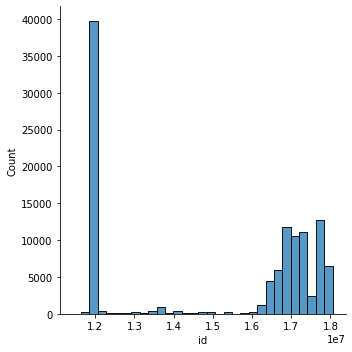

<Figure size 864x360 with 0 Axes>

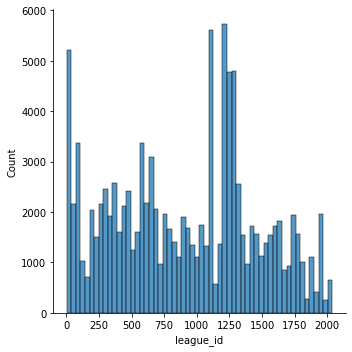

<Figure size 864x360 with 0 Axes>

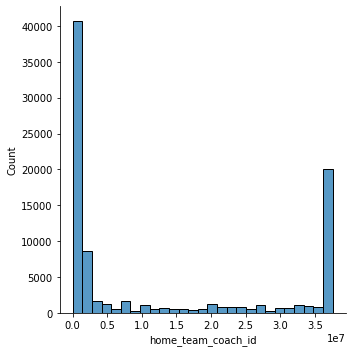

<Figure size 864x360 with 0 Axes>

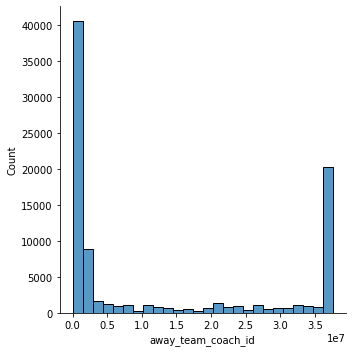

<Figure size 864x360 with 0 Axes>

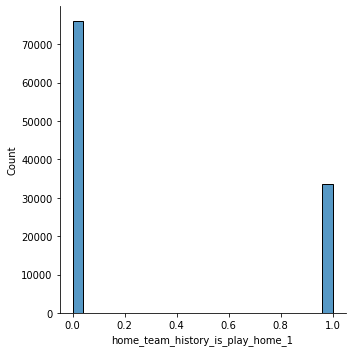

<Figure size 864x360 with 0 Axes>

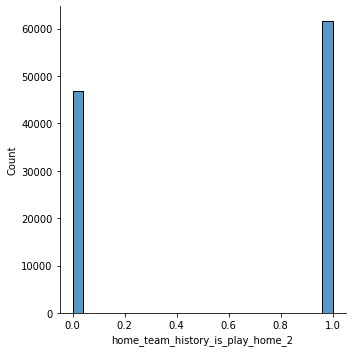

<Figure size 864x360 with 0 Axes>

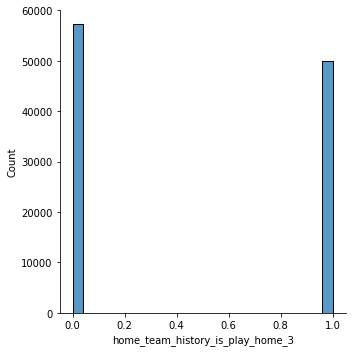

<Figure size 864x360 with 0 Axes>

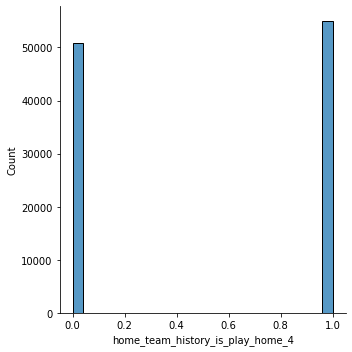

<Figure size 864x360 with 0 Axes>

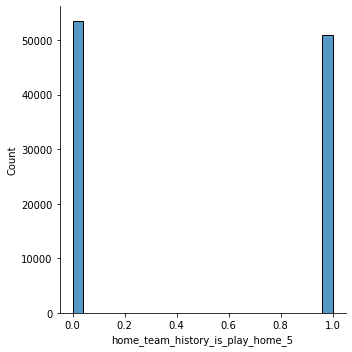

<Figure size 864x360 with 0 Axes>

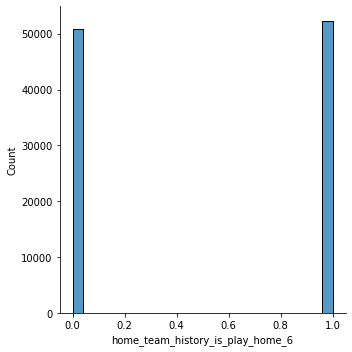

<Figure size 864x360 with 0 Axes>

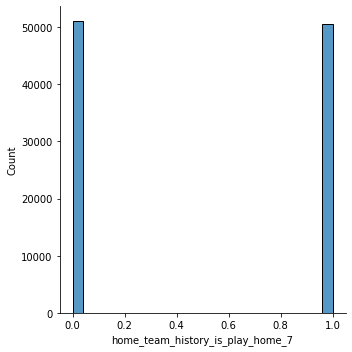

<Figure size 864x360 with 0 Axes>

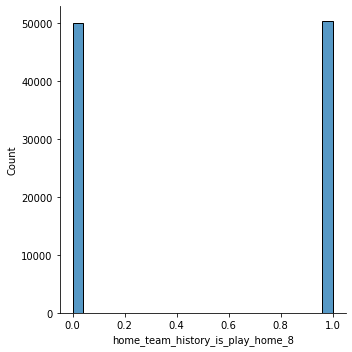

<Figure size 864x360 with 0 Axes>

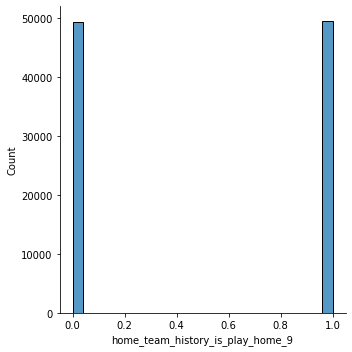

<Figure size 864x360 with 0 Axes>

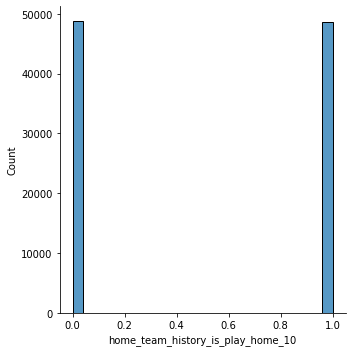

<Figure size 864x360 with 0 Axes>

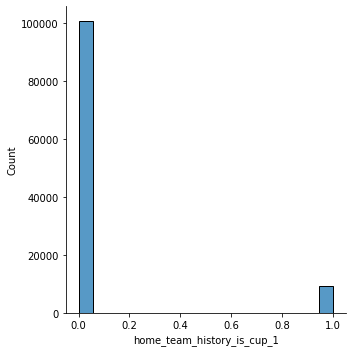

<Figure size 864x360 with 0 Axes>

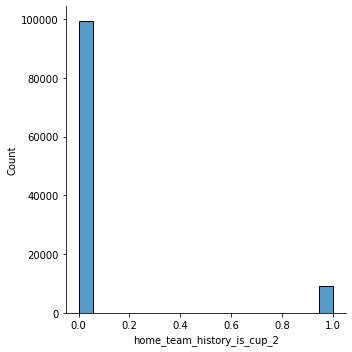

<Figure size 864x360 with 0 Axes>

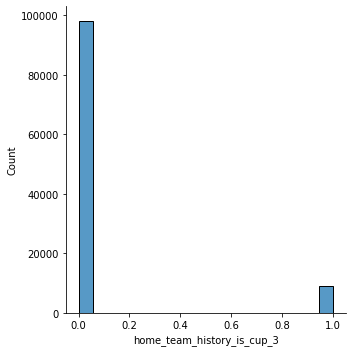

<Figure size 864x360 with 0 Axes>

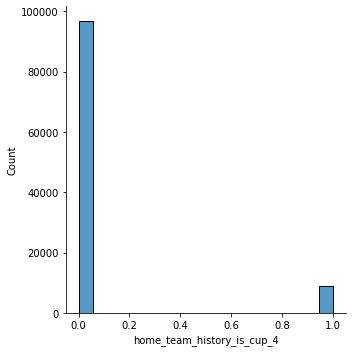

<Figure size 864x360 with 0 Axes>

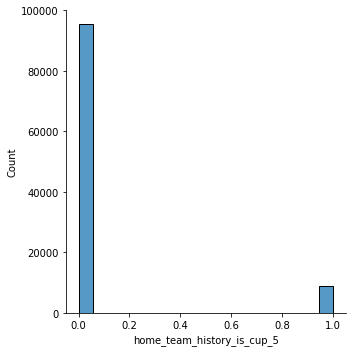

<Figure size 864x360 with 0 Axes>

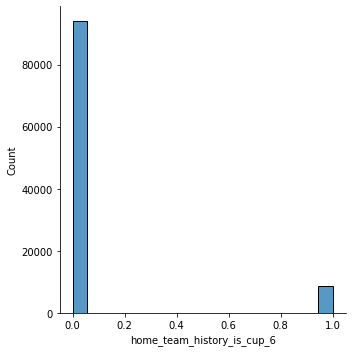

In [18]:
numeric_distribution_plot(train)

### Deriving insights from data

In [19]:
# let's encode the target class

train['target'].value_counts()

home    48113
away    35174
draw    27651
Name: target, dtype: int64

In [20]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(train['target'])

train['target'] = encoder.transform(train['target'])

train['target'].value_counts()

2    48113
0    35174
1    27651
Name: target, dtype: int64

From the above, we see the classes are encoded 0 - away, 1 - draw and 2 - home. 

Now, we can check the correlation of the numeric features with the target.

In [21]:
corr = train.corr()['target']

print("The 15 features with the highest correlations with the target are: \n", corr.sort_values(ascending=False).head(10))
print('\n')
print("The 15 features with the lowest correlations with the target are: \n", corr.sort_values(ascending=False).tail(10))

The 15 features with the highest correlations with the target are: 
 target                                 1.000000
home_team_history_rating_2             0.108375
home_team_history_rating_1             0.104404
away_team_history_opponent_rating_1    0.104002
away_team_history_opponent_rating_2    0.101542
home_team_history_rating_3             0.098628
home_team_history_rating_5             0.096691
home_team_history_rating_6             0.095669
home_team_history_rating_4             0.095663
away_team_history_opponent_rating_4    0.094041
Name: target, dtype: float64


The 15 features with the lowest correlations with the target are: 
 home_team_history_opponent_rating_4   -0.106171
away_team_history_rating_5            -0.106624
away_team_history_rating_6            -0.107669
away_team_history_rating_3            -0.109831
away_team_history_rating_4            -0.110319
home_team_history_opponent_rating_3   -0.114486
home_team_history_opponent_rating_2   -0.116356
away_team_histor

Clearly the ratings features are important as they dominate the top 15 and bottom 15 correlations with the target. 

What do these correlations mean?
From the target we encoded, we know that 0 refers to away wins, 1 refers to draws and 2 refers to home wins. The higher correlations with the target like home_team_history_rating_2 and home_team_history_rating_1 refer to likeliness of draws and home wins. For example, games with higer home_team_history_rating_2 will more likely have home wins and draws. 

Similarly, the lower correlations with the target like away_team_history_rating_1 amd home_team_history_opponent_rating_1 with the target refer to likeliness of draws and away wins. 

Let's have a kde plot of some of the features to see how it affects the different classes clearly

In [22]:
plt.style.use('fivethirtyeight')
sns.set(rc = {'figure.figsize':(10,8)})

def kde_plot(df, col):
    
    # print mean information of col by target
    away_mean = df.loc[df['target'] == 0, col].mean()
    draws_mean = df.loc[df['target'] == 1, col].mean()
    home_mean = df.loc[df['target'] == 2, col].mean()
    
    print(f"The average {col} for the home wins: {round(home_mean, 2)}")
    print(f"The average {col} for the away wins: {round(away_mean, 2)}")
    print(f"The average {col} for the draws: {round(draws_mean, 2)}")
    
    # kde distribution for each of the target classes
    sns.kdeplot(df.loc[df['target'] == 0, col], label = 'target == away')
    sns.kdeplot(df.loc[df['target'] == 1, col], label = 'target == draws')
    sns.kdeplot(df.loc[df['target'] == 2, col], label = 'target == home')
    
    plt.title(f"Distribution of {col} by target")
    plt.xlabel(f"{col}")
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout(h_pad = 2.5)
    

#### home_team_history_rating_2

The average home_team_history_rating_2 for the home wins: 7.01
The average home_team_history_rating_2 for the away wins: 6.36
The average home_team_history_rating_2 for the draws: 6.39


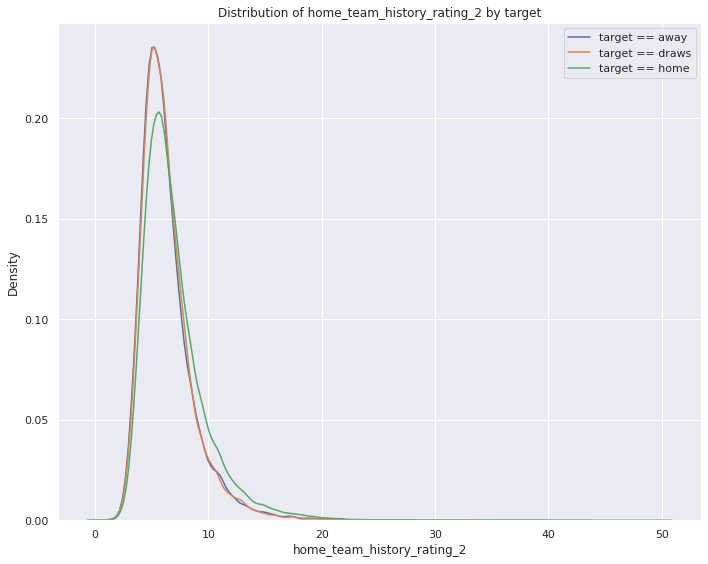

In [23]:
kde_plot(train, 'home_team_history_rating_2')

In [24]:
train['home_team_history_rating_2'].describe()

count    108472.000000
mean          6.651585
std           2.693074
min           0.255600
25%           4.913283
50%           6.046611
75%           7.665168
max          49.969875
Name: home_team_history_rating_2, dtype: float64

<AxesSubplot:xlabel='home_team_history_rating_2'>

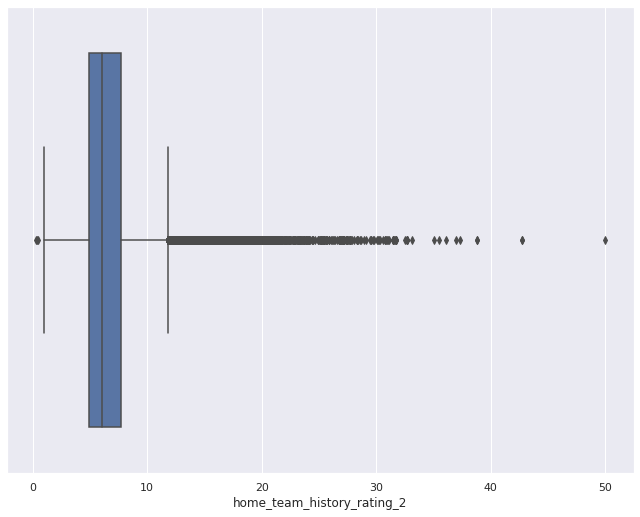

In [25]:
# let's see a boxplot of this feature

sns.boxplot(x='home_team_history_rating_2', data=train)

Let's observe the outliers from this feature - home_team_history_rating_2...

In [26]:
train.loc[train['home_team_history_rating_2'] == train['home_team_history_rating_2'].max()]

,id,target,home_team_name,away_team_name,match_date,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,...,away_team_history_league_id_1,away_team_history_league_id_2,away_team_history_league_id_3,away_team_history_league_id_4,away_team_history_league_id_5,away_team_history_league_id_6,away_team_history_league_id_7,away_team_history_league_id_8,away_team_history_league_id_9,away_team_history_league_id_10
31388,16141534,0,Zorka-BDU W,Dinamo-BGU W,2020-07-08 14:00:00,Women's Cup,1870,True,58142.0,37352370.0,...,1869.0,1869.0,1869.0,1869.0,1869.0,1869.0,1869.0,1869.0,NaN,NaN


The average home_team_history_rating_2 of the outliers: 23.95
The average home_team_history_rating_2 for the home wins: 24.1
The average home_team_history_rating_2 for the away wins: 23.56
The average home_team_history_rating_2 for the draws: 24.08


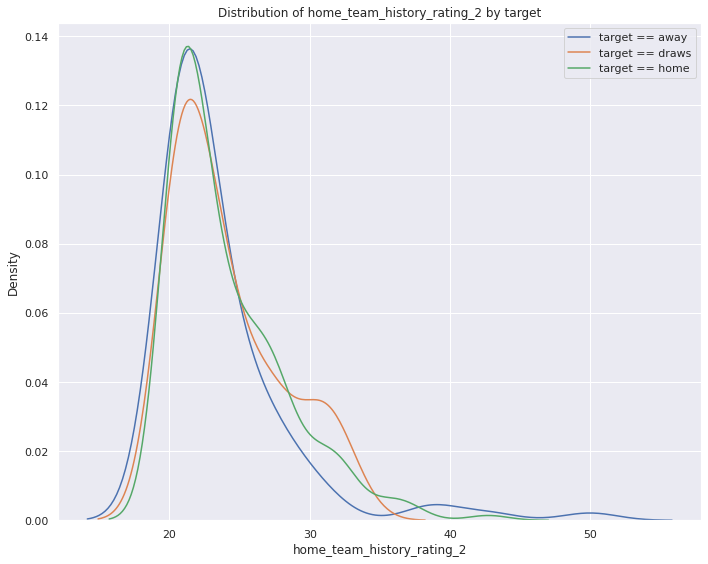

In [27]:
# let's see the ratings that are above 20 - arbitrarily chosen value above the top of the boxplot and plot the kde

temp = train.loc[train['home_team_history_rating_2'] > 20]

outlier_ratingmean = temp['home_team_history_rating_2'].mean()
print(f"The average home_team_history_rating_2 of the outliers: {round(outlier_ratingmean, 2)}")

kde_plot(temp, 'home_team_history_rating_2')

From the investigation above, we see that the outliers have a similar distribution to the general dataset. I have decided to not remove these outlier values since a. they're minorities compared to the full dataset (mean of 23.95 vs 6.65) b. they do not alter the distribution of our full dataset.

In both cases, there is a very slight difference in the plots shown in the different classes and as reported by the correlation matrix, we see that the feature contributes to the target but not very strongly. We see a slightly higher average in the home wins for the feature compared to the draws and away wins as predicted by the correlation matrix.

Let's see the case of a negative correlation (more away wins)

#### home_team_history_opponent_rating_1

The average home_team_history_opponent_rating_1 for the home wins: 6.47
The average home_team_history_opponent_rating_1 for the away wins: 7.26
The average home_team_history_opponent_rating_1 for the draws: 6.59


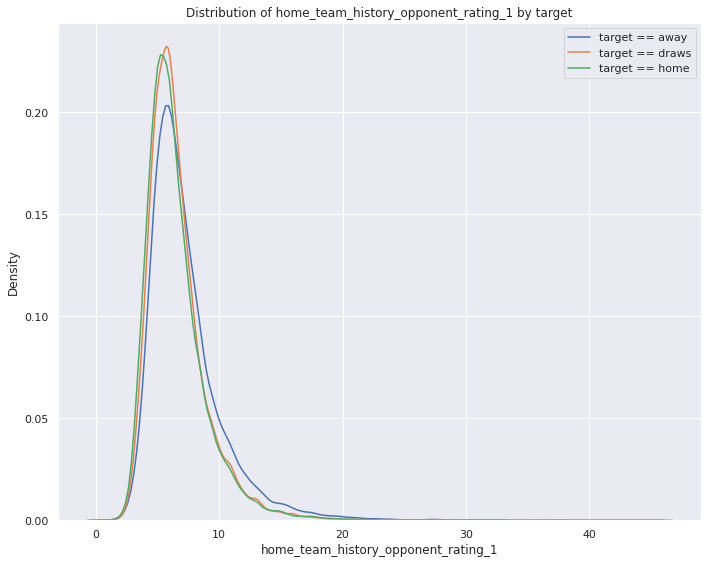

In [28]:
kde_plot(train, 'home_team_history_opponent_rating_1')

In [29]:
train['home_team_history_opponent_rating_1'].describe()

count    109767.000000
mean          6.749435
std           2.650877
min           0.407900
25%           5.032736
50%           6.169300
75%           7.766535
max          45.849650
Name: home_team_history_opponent_rating_1, dtype: float64

We see similar observations here as well. Just like before, we see slight correlations with the contributions to the target. In this case, the mean of away wins for the feature is slightly higher than for home and draws, as already explained. 

Since the ratings feature is very important, we should aggregate them and see how much of a contribution to the target, the aggregate makes

### aggregating the historical ratings features

In [30]:
train.columns[160:180]

Index(['away_team_history_opponent_rating_1',
       'away_team_history_opponent_rating_2',
       'away_team_history_opponent_rating_3',
       'away_team_history_opponent_rating_4',
       'away_team_history_opponent_rating_5',
       'away_team_history_opponent_rating_6',
       'away_team_history_opponent_rating_7',
       'away_team_history_opponent_rating_8',
       'away_team_history_opponent_rating_9',
       'away_team_history_opponent_rating_10', 'away_team_history_coach_1',
       'away_team_history_coach_2', 'away_team_history_coach_3',
       'away_team_history_coach_4', 'away_team_history_coach_5',
       'away_team_history_coach_6', 'away_team_history_coach_7',
       'away_team_history_coach_8', 'away_team_history_coach_9',
       'away_team_history_coach_10'],
      dtype='object')

In [31]:
homerating_features = ['home_team_history_rating_1', 'home_team_history_rating_2', 'home_team_history_rating_3', 'home_team_history_rating_4', 
                      'home_team_history_rating_5', 'home_team_history_rating_6', 'home_team_history_rating_7', 'home_team_history_rating_8', 
                      'home_team_history_rating_9', 'home_team_history_rating_10']

awayrating_features = ['away_team_history_rating_1', 'away_team_history_rating_2', 'away_team_history_rating_3', 'away_team_history_rating_4', 
                      'away_team_history_rating_5', 'away_team_history_rating_6', 'away_team_history_rating_7', 'away_team_history_rating_8', 
                      'away_team_history_rating_9', 'away_team_history_rating_10']

homeopponent_features = ['home_team_history_opponent_rating_1', 'home_team_history_opponent_rating_2', 'home_team_history_opponent_rating_3', 
                          'home_team_history_opponent_rating_4', 'home_team_history_opponent_rating_5', 'home_team_history_opponent_rating_6', 
                          'home_team_history_opponent_rating_7', 'home_team_history_opponent_rating_8', 'home_team_history_opponent_rating_9', 
                          'home_team_history_opponent_rating_10']

awayopponent_features = ['away_team_history_opponent_rating_1', 'away_team_history_opponent_rating_2', 'away_team_history_opponent_rating_3', 
                        'away_team_history_opponent_rating_4', 'away_team_history_opponent_rating_5', 'away_team_history_opponent_rating_6', 
                        'away_team_history_opponent_rating_7', 'away_team_history_opponent_rating_8', 'away_team_history_opponent_rating_9', 
                        'away_team_history_opponent_rating_10']

# let's create the aggregate of these features in the train and test
train['home_rating_norm'] = train[homerating_features].mean(axis=1)
train['away_rating_norm'] = train[awayrating_features].mean(axis=1)
train['home_opponent_norm'] = train[homeopponent_features].mean(axis=1)
train['away_opponent_norm'] = train[awayopponent_features].mean(axis=1)

In [32]:
# for the test
test['home_rating_norm'] = test[homerating_features].mean(axis=1)
test['away_rating_norm'] = test[awayrating_features].mean(axis=1)
test['home_opponent_norm'] = test[homeopponent_features].mean(axis=1)
test['away_opponent_norm'] = test[awayopponent_features].mean(axis=1)

train.shape, test.shape

((110938, 194), (72711, 193))

In [33]:
# let's see the correlations again
corr = train.corr()['target']

print("The 15 features with the highest correlations with the target are: \n", corr.sort_values(ascending=False).head(10))
print('\n')
print("The 15 features with the lowest correlations with the target are: \n", corr.sort_values(ascending=False).tail(10))

The 15 features with the highest correlations with the target are: 
 target                                 1.000000
home_rating_norm                       0.138057
away_opponent_norm                     0.134835
home_team_history_rating_2             0.108375
home_team_history_rating_1             0.104404
away_team_history_opponent_rating_1    0.104002
away_team_history_opponent_rating_2    0.101542
home_team_history_rating_3             0.098628
home_team_history_rating_5             0.096691
home_team_history_rating_6             0.095669
Name: target, dtype: float64


The 15 features with the lowest correlations with the target are: 
 away_team_history_rating_6            -0.107669
away_team_history_rating_3            -0.109831
away_team_history_rating_4            -0.110319
home_team_history_opponent_rating_3   -0.114486
home_team_history_opponent_rating_2   -0.116356
away_team_history_rating_2            -0.117092
away_team_history_rating_1            -0.123964
home_team_histor

As we see from the correlation matrix above, the newly added 4 features - home_rating_norm, away_opponent_norm, away_rating_norm and home_opponent_norm are slightly more positively and negatively correlated with the target than the features alone. Let's have a kde plot for these new features added to gain moe insight.

The average home_rating_norm for the home wins: 6.88
The average home_rating_norm for the away wins: 6.31
The average home_rating_norm for the draws: 6.29


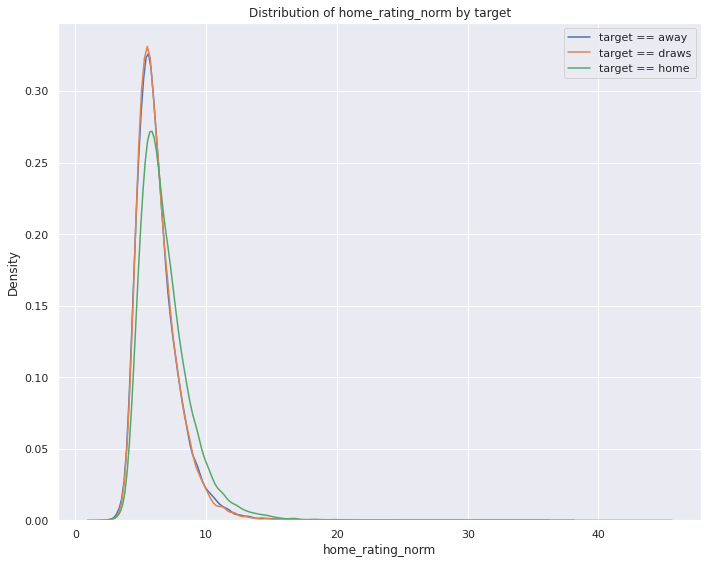

In [34]:
kde_plot(train, 'home_rating_norm')

The average away_rating_norm for the home wins: 6.33
The average away_rating_norm for the away wins: 7.03
The average away_rating_norm for the draws: 6.41


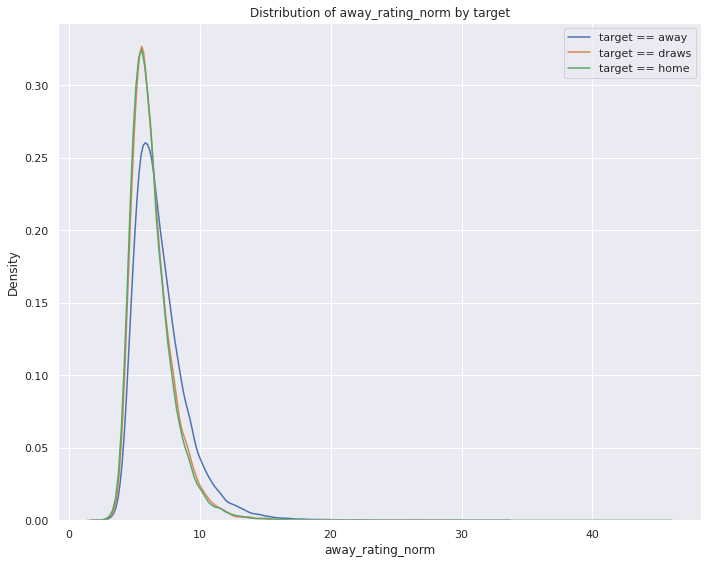

In [35]:
kde_plot(train, 'away_rating_norm')

The average home_opponent_norm for the home wins: 6.31
The average home_opponent_norm for the away wins: 7.01
The average home_opponent_norm for the draws: 6.4


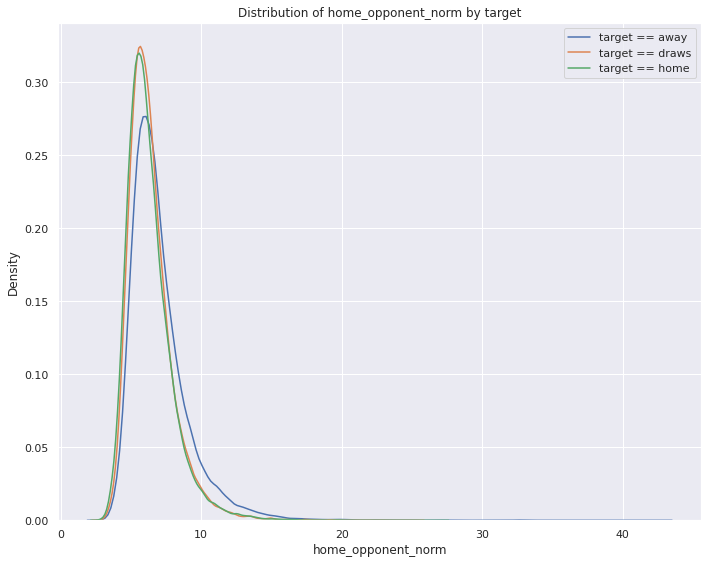

In [36]:
kde_plot(train, 'home_opponent_norm')

The average away_opponent_norm for the home wins: 6.85
The average away_opponent_norm for the away wins: 6.29
The average away_opponent_norm for the draws: 6.29


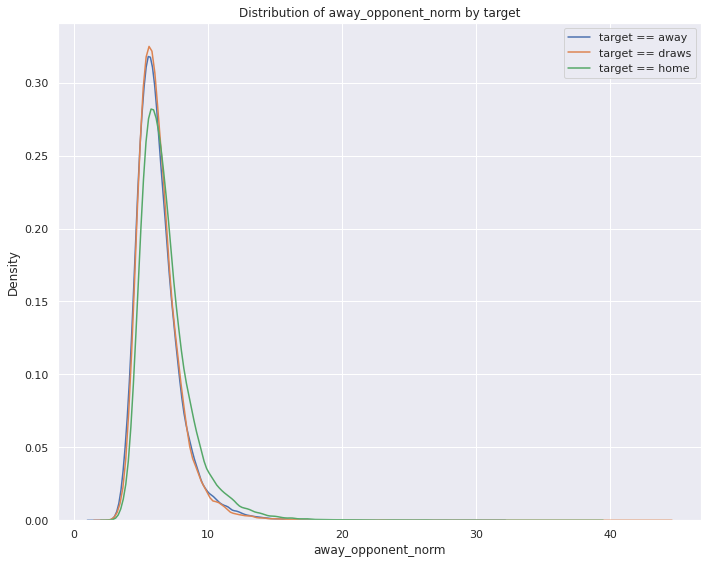

In [37]:
kde_plot(train, 'away_opponent_norm')

### Additional Insights from the data

We have derived some insights from the rating features available in the data given and have added features based on these insights. Let's see some the historical features available in the datset from which we could gain more insights and engineer the features.

In [38]:
# let's see the dataframe again

train.head()

,id,target,home_team_name,away_team_name,match_date,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,...,away_team_history_league_id_5,away_team_history_league_id_6,away_team_history_league_id_7,away_team_history_league_id_8,away_team_history_league_id_9,away_team_history_league_id_10,home_rating_norm,away_rating_norm,home_opponent_norm,away_opponent_norm
0,11906497,0,Newell's Old Boys,River Plate,2019-12-01 00:45:00,Superliga,636,False,468196.0,468200.0,...,636.0,1122.0,636.0,642.0,636.0,1122.0,5.496371,8.561214,4.400204,3.808902
1,11984383,2,Real Estelí,Deportivo Las Sabanas,2019-12-01 01:00:00,Primera Division,752,False,516788.0,22169161.0,...,752.0,752.0,752.0,752.0,752.0,752.0,8.440839,5.287316,4.546772,6.822376
2,11983301,1,UPNFM,Marathón,2019-12-01 01:00:00,Liga Nacional,734,False,2510608.0,456313.0,...,734.0,734.0,734.0,734.0,734.0,734.0,6.844712,7.620071,5.547477,5.188232
3,11983471,0,León,Morelia,2019-12-01 01:00:00,Liga MX,743,False,1552508.0,465797.0,...,743.0,743.0,743.0,743.0,746.0,743.0,7.449923,5.818128,4.983015,6.469250
4,11883005,2,Cobán Imperial,Iztapa,2019-12-01 01:00:00,Liga Nacional,705,False,429958.0,426870.0,...,705.0,705.0,705.0,705.0,705.0,705.0,7.079634,5.983338,5.192975,6.027979


Looking at the features description given, the features that should contribute to the correlation of the target should be the ```home_team_history_goal-{i}``` and the ```home_team_history_opponent_goal_{i}``` and the same for the away teams. Before we look at the correlations these features might have with the target or even aggregating them, let's understand what type of information they contain

In [39]:
temp = ['home_team_history_goal_1', 'away_team_history_goal_1','home_team_history_opponent_goal_1', 'away_team_history_opponent_goal_1']

train[temp].head()

,home_team_history_goal_1,away_team_history_goal_1,home_team_history_opponent_goal_1,away_team_history_opponent_goal_1
0,0.0,1.0,1.0,2.0
1,0.0,1.0,2.0,0.0
2,3.0,3.0,1.0,1.0
3,3.0,3.0,3.0,3.0
4,1.0,4.0,2.0,1.0


* ```home_team_history_goal_1``` refers to the number of goals scored by the home team in the last 1 game
* ```away_team_history_goal_1``` refers to the number of goals scored by the away team in the last 1 game
* ```home_team_history_opponent_goal_1``` refers to the number of goals conceded by the home team in the last 1 game
* ```away_team_history_opponent_goal_1``` refers to the number of goals conceded by the away team in the last 1 game

In [40]:
# let's see the correlations of these features with the target

corr1 = train['target'].corr(train['home_team_history_goal_1'])
corr2 = train['target'].corr(train['away_team_history_goal_1'])
corr3 = train['target'].corr(train['home_team_history_opponent_goal_1'])
corr4 = train['target'].corr(train['away_team_history_opponent_goal_1'])

l = [corr1, corr2, corr3, corr4]
print(l)

[0.06674525389123291, -0.07259083483120264, -0.07974634087920696, 0.07163005904410363]


These features have even weaker correlations with the target. Everything discussed about positive and negative correlations with the target earlier hold for these features as well.

In [41]:
# let's aggregate the features

homehistory_goals = ['home_team_history_goal_1', 'home_team_history_goal_2', 'home_team_history_goal_3', 'home_team_history_goal_4',
                     'home_team_history_goal_5', 'home_team_history_goal_6', 'home_team_history_goal_7', 'home_team_history_goal_8',
                     'home_team_history_goal_9', 'home_team_history_goal_10']

awayhistory_goals = ['away_team_history_goal_1', 'away_team_history_goal_2', 'away_team_history_goal_3', 'away_team_history_goal_4', 
                    'away_team_history_goal_5', 'away_team_history_goal_6', 'away_team_history_goal_7', 'away_team_history_goal_8', 
                    'away_team_history_goal_9', 'away_team_history_goal_10']

homeopponent_goals = ['home_team_history_opponent_goal_1', 'home_team_history_opponent_goal_2', 'home_team_history_opponent_goal_3', 
                     'home_team_history_opponent_goal_4', 'home_team_history_opponent_goal_5', 'home_team_history_opponent_goal_6', 
                     'home_team_history_opponent_goal_7', 'home_team_history_opponent_goal_8', 'home_team_history_opponent_goal_9', 
                     'home_team_history_opponent_goal_10']

awayopponent_goals = ['away_team_history_opponent_goal_1', 'away_team_history_opponent_goal_2', 'away_team_history_opponent_goal_3', 
                     'away_team_history_opponent_goal_4', 'away_team_history_opponent_goal_5', 'away_team_history_opponent_goal_6', 
                     'away_team_history_opponent_goal_7', 'away_team_history_opponent_goal_8', 'away_team_history_opponent_goal_9',
                     'away_team_history_opponent_goal_10']

# let's aggregate the features for train and test

train['home_goals_norm'] = train[homehistory_goals].mean(axis=1)
train['away_goals_norm'] = train[awayhistory_goals].mean(axis=1)
train['home_goalsopp_norm'] = train[homeopponent_goals].mean(axis=1)
train['away_goalsopp_norm'] = train[awayopponent_goals].mean(axis=1)

test['home_goals_norm'] = test[homehistory_goals].mean(axis=1)
test['away_goals_norm'] = test[awayhistory_goals].mean(axis=1)
test['home_goalsopp_norm'] = test[homeopponent_goals].mean(axis=1)
test['away_goalsopp_norm'] = test[awayopponent_goals].mean(axis=1)

train.shape, test.shape

((110938, 198), (72711, 197))

In [42]:
train.head()

,id,target,home_team_name,away_team_name,match_date,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,...,away_team_history_league_id_9,away_team_history_league_id_10,home_rating_norm,away_rating_norm,home_opponent_norm,away_opponent_norm,home_goals_norm,away_goals_norm,home_goalsopp_norm,away_goalsopp_norm
0,11906497,0,Newell's Old Boys,River Plate,2019-12-01 00:45:00,Superliga,636,False,468196.0,468200.0,...,636.0,1122.0,5.496371,8.561214,4.400204,3.808902,1.3,1.6,1.0,0.9
1,11984383,2,Real Estelí,Deportivo Las Sabanas,2019-12-01 01:00:00,Primera Division,752,False,516788.0,22169161.0,...,752.0,752.0,8.440839,5.287316,4.546772,6.822376,0.9,0.8,1.0,1.4
2,11983301,1,UPNFM,Marathón,2019-12-01 01:00:00,Liga Nacional,734,False,2510608.0,456313.0,...,734.0,734.0,6.844712,7.620071,5.547477,5.188232,1.9,2.1,1.7,1.1
3,11983471,0,León,Morelia,2019-12-01 01:00:00,Liga MX,743,False,1552508.0,465797.0,...,746.0,743.0,7.449923,5.818128,4.983015,6.469250,1.8,2.4,1.3,2.0
4,11883005,2,Cobán Imperial,Iztapa,2019-12-01 01:00:00,Liga Nacional,705,False,429958.0,426870.0,...,705.0,705.0,7.079634,5.983338,5.192975,6.027979,1.8,1.8,1.4,1.0


In [43]:
# let's see if they show up in the correlation now

# let's see the correlations again
corr = train.corr()['target']

print("The 15 features with the highest correlations with the target are: \n", corr.sort_values(ascending=False).head(10))
print('\n')
print("The 15 features with the lowest correlations with the target are: \n", corr.sort_values(ascending=False).tail(10))

The 15 features with the highest correlations with the target are: 
 target                                 1.000000
home_rating_norm                       0.138057
away_opponent_norm                     0.134835
away_goalsopp_norm                     0.133439
home_goals_norm                        0.130847
home_team_history_rating_2             0.108375
home_team_history_rating_1             0.104404
away_team_history_opponent_rating_1    0.104002
away_team_history_opponent_rating_2    0.101542
home_team_history_rating_3             0.098628
Name: target, dtype: float64


The 15 features with the lowest correlations with the target are: 
 away_team_history_rating_4            -0.110319
home_team_history_opponent_rating_3   -0.114486
home_team_history_opponent_rating_2   -0.116356
away_team_history_rating_2            -0.117092
away_team_history_rating_1            -0.123964
home_team_history_opponent_rating_1   -0.124314
away_goals_norm                       -0.141275
home_goalsopp_no

As we see now, the features contribute to the target as they both show up in both the positive and negative correlations.

#### Dropping date features

Now, it's unlikely that date features will contribute to the predictive power of the model we're trying to build. The date features refer to the dates the current match was played and to the dates the previous i matches were played. We'll drop all of these columns from the datasets

In [44]:
datefeatures = ['match_date', 'home_team_history_match_date_1', 'home_team_history_match_date_2', 'home_team_history_match_date_3', 'home_team_history_match_date_4',
               'home_team_history_match_date_5', 'home_team_history_match_date_6', 'home_team_history_match_date_7', 'home_team_history_match_date_8', 'home_team_history_match_date_9', 'home_team_history_match_date_10', 
               'away_team_history_match_date_1', 'away_team_history_match_date_2', 'away_team_history_match_date_3', 'away_team_history_match_date_4', 'away_team_history_match_date_5', 
               'away_team_history_match_date_6', 'away_team_history_match_date_7', 'away_team_history_match_date_8', 'away_team_history_match_date_9', 'away_team_history_match_date_10']

train = train.drop(columns=datefeatures)
test = test.drop(columns=datefeatures)

train.shape, test.shape

((110938, 177), (72711, 176))

#### historical is_cup and is_play_home

In [45]:
temp = ['home_team_history_is_cup_1', 'away_team_history_is_cup_1', 'home_team_history_is_play_home_1',
            'away_team_history_is_play_home_1']

train[temp].head()

,home_team_history_is_cup_1,away_team_history_is_cup_1,home_team_history_is_play_home_1,away_team_history_is_play_home_1
0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0


In [46]:
# let's see their correlations with the target

corr1 = train['target'].corr(train['home_team_history_is_cup_1'])
corr2 = train['target'].corr(train['away_team_history_is_cup_1'])
corr3 = train['target'].corr(train['home_team_history_is_play_home_1'])
corr4 = train['target'].corr(train['away_team_history_is_play_home_1'])

l = [corr1, corr2, corr3, corr4]
print(l)

[0.019156946504099978, -0.013946020944530695, 0.004875232289804165, -0.0020523842267954557]


Correlations are low as observed with other features, and positive and negative signs are as described for others. 
the ```home_team_history_is_cup_{i}``` refers to if the home team last i games were cup competition and the ```home_team_history_is_play_home_{i}``` refers to if the home team last i games were played at home and similar definitions for the away prefixes. These features have a value of 1 if True and 0 for False. Let's aggregate the features. I've decided to use the median for these features since they're flags (1 or 0)

In [47]:
home_iscup = ['home_team_history_is_cup_1', 'home_team_history_is_cup_2', 'home_team_history_is_cup_3', 'home_team_history_is_cup_4', 
             'home_team_history_is_cup_5', 'home_team_history_is_cup_6', 'home_team_history_is_cup_7', 'home_team_history_is_cup_8', 
             'home_team_history_is_cup_9', 'home_team_history_is_cup_10']

away_iscup = ['away_team_history_is_cup_1', 'away_team_history_is_cup_2', 'away_team_history_is_cup_3', 'away_team_history_is_cup_4', 
             'away_team_history_is_cup_5', 'away_team_history_is_cup_6', 'away_team_history_is_cup_7', 'away_team_history_is_cup_8', 
             'away_team_history_is_cup_9', 'away_team_history_is_cup_10']

home_ishome = ['home_team_history_is_play_home_1', 'home_team_history_is_play_home_2', 'home_team_history_is_play_home_3', 'home_team_history_is_play_home_4', 
              'home_team_history_is_play_home_5', 'home_team_history_is_play_home_6', 'home_team_history_is_play_home_7', 'home_team_history_is_play_home_8', 
              'home_team_history_is_play_home_9', 'home_team_history_is_play_home_10']

away_ishome = ['away_team_history_is_play_home_1', 'away_team_history_is_play_home_2', 'away_team_history_is_play_home_3', 'away_team_history_is_play_home_4', 
              'away_team_history_is_play_home_5', 'away_team_history_is_play_home_6', 'away_team_history_is_play_home_7', 'away_team_history_is_play_home_8',
              'away_team_history_is_play_home_9', 'away_team_history_is_play_home_10']

train['home_iscup_norm'] = train[home_iscup].median(axis=1)
train['away_iscup_norm'] = train[away_iscup].median(axis=1)
train['home_ishome_norm'] = train[home_ishome].median(axis=1)
train['away_ishome_norm'] = train[away_ishome].median(axis=1)

test['home_iscup_norm'] = test[home_iscup].median(axis=1)
test['away_iscup_norm'] = test[away_iscup].median(axis=1)
test['home_ishome_norm'] = test[home_ishome].median(axis=1)
test['away_ishome_norm'] = test[away_ishome].median(axis=1)

train.shape, test.shape

((110938, 181), (72711, 180))

In [48]:
train.head()

,id,target,home_team_name,away_team_name,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,home_team_history_is_play_home_1,...,home_opponent_norm,away_opponent_norm,home_goals_norm,away_goals_norm,home_goalsopp_norm,away_goalsopp_norm,home_iscup_norm,away_iscup_norm,home_ishome_norm,away_ishome_norm
0,11906497,0,Newell's Old Boys,River Plate,Superliga,636,False,468196.0,468200.0,0.0,...,4.400204,3.808902,1.3,1.6,1.0,0.9,0.0,0.5,0.5,1.0
1,11984383,2,Real Estelí,Deportivo Las Sabanas,Primera Division,752,False,516788.0,22169161.0,1.0,...,4.546772,6.822376,0.9,0.8,1.0,1.4,0.0,0.0,0.5,0.5
2,11983301,1,UPNFM,Marathón,Liga Nacional,734,False,2510608.0,456313.0,0.0,...,5.547477,5.188232,1.9,2.1,1.7,1.1,0.0,0.0,0.5,0.5
3,11983471,0,León,Morelia,Liga MX,743,False,1552508.0,465797.0,0.0,...,4.983015,6.469250,1.8,2.4,1.3,2.0,0.0,0.0,0.5,0.5
4,11883005,2,Cobán Imperial,Iztapa,Liga Nacional,705,False,429958.0,426870.0,0.0,...,5.192975,6.027979,1.8,1.8,1.4,1.0,0.0,0.0,0.5,1.0


In [49]:
# let's see the correlations again
corr = train.corr()['target']

print("The 15 features with the highest correlations with the target are: \n", corr.sort_values(ascending=False).head(10))
print('\n')
print("The 15 features with the lowest correlations with the target are: \n", corr.sort_values(ascending=False).tail(10))

The 15 features with the highest correlations with the target are: 
 target                                 1.000000
home_rating_norm                       0.138057
away_opponent_norm                     0.134835
away_goalsopp_norm                     0.133439
home_goals_norm                        0.130847
home_team_history_rating_2             0.108375
home_team_history_rating_1             0.104404
away_team_history_opponent_rating_1    0.104002
away_team_history_opponent_rating_2    0.101542
home_team_history_rating_3             0.098628
Name: target, dtype: float64


The 15 features with the lowest correlations with the target are: 
 away_team_history_rating_4            -0.110319
home_team_history_opponent_rating_3   -0.114486
home_team_history_opponent_rating_2   -0.116356
away_team_history_rating_2            -0.117092
away_team_history_rating_1            -0.123964
home_team_history_opponent_rating_1   -0.124314
away_goals_norm                       -0.141275
home_goalsopp_no

These new features do not show up in our top 15 and bottom 15 correlations with the target. This means their correlations are much weaker compared to the other features.

Since, we're done with the transforming the historical features to gather better insights from the data given, let's define the new features created.

* ```home_rating_norm``` refers to the average of ratings of the home team of the current match in their last 10 games
* ```away_rating_norm``` refers to the average of ratings of the away team of the current match in their last 10 games
* ```home_opponent_norm``` refers to the average of ratings of the opponents of the home team of the current match in the last 10 games
* ```away_opponent_norm``` refers to the average of ratings of the opponents of the away team of the current match in the last 10 games
* ```home_goals_norm``` refers to the average of the goals scored by the home team of the current match in their last 10 games
* ```away_goals_norm``` refers to the average of the goals scored by the away team of the current match in their last 10 games
* ```home_goalsopp_norm``` refers to the average of the goals scored by the opponents of the home team in their last 10 games
* ```away_goalsopp_norm``` refers to the average of the goals scored by the opponents of the away team in their last 10 games
* ```home_iscup_norm``` refers to average of flag times games played by the home team of the current match played a cup comp in their last 10 games
* ```away_iscup_norm``` refers to the average of flag times games played by the away team of the current match played a cup comp in their last 10 games
* ```home_ishome_norm``` refers to the average of flag times the home team of the current match played at home in their last 10 games
* ```away_ishome_norm``` refers to the average of flag times the away team of the current match played at home in their last 10 games

### Categorical Encoding

In [50]:
train.head()

,id,target,home_team_name,away_team_name,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,home_team_history_is_play_home_1,...,home_opponent_norm,away_opponent_norm,home_goals_norm,away_goals_norm,home_goalsopp_norm,away_goalsopp_norm,home_iscup_norm,away_iscup_norm,home_ishome_norm,away_ishome_norm
0,11906497,0,Newell's Old Boys,River Plate,Superliga,636,False,468196.0,468200.0,0.0,...,4.400204,3.808902,1.3,1.6,1.0,0.9,0.0,0.5,0.5,1.0
1,11984383,2,Real Estelí,Deportivo Las Sabanas,Primera Division,752,False,516788.0,22169161.0,1.0,...,4.546772,6.822376,0.9,0.8,1.0,1.4,0.0,0.0,0.5,0.5
2,11983301,1,UPNFM,Marathón,Liga Nacional,734,False,2510608.0,456313.0,0.0,...,5.547477,5.188232,1.9,2.1,1.7,1.1,0.0,0.0,0.5,0.5
3,11983471,0,León,Morelia,Liga MX,743,False,1552508.0,465797.0,0.0,...,4.983015,6.469250,1.8,2.4,1.3,2.0,0.0,0.0,0.5,0.5
4,11883005,2,Cobán Imperial,Iztapa,Liga Nacional,705,False,429958.0,426870.0,0.0,...,5.192975,6.027979,1.8,1.8,1.4,1.0,0.0,0.0,0.5,1.0


In [51]:
# the is_cup feature
encoder = LabelEncoder()
encoder.fit(train['is_cup'])

train['is_cup'] = encoder.transform(train['is_cup'])
train.shape, test.shape

((110938, 181), (72711, 180))

In [52]:
encoder = LabelEncoder()
test['is_cup'] = encoder.fit_transform(test['is_cup'])

In [53]:
test.head()

,id,home_team_name,away_team_name,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,home_team_history_is_play_home_1,home_team_history_is_play_home_2,...,home_opponent_norm,away_opponent_norm,home_goals_norm,away_goals_norm,home_goalsopp_norm,away_goalsopp_norm,home_iscup_norm,away_iscup_norm,home_ishome_norm,away_ishome_norm
0,17761448,team home,team away,Division 1,755,0,9605704.0,30866250.0,0.0,0.0,...,7.408696,6.221093,1.0,1.1,0.6,1.4,0.0,0.0,0.0,0.5
1,17695487,team home,team away,Liga MX,743,0,10319425.0,460370.0,0.0,1.0,...,6.435353,5.629701,0.7,1.0,1.4,1.0,0.0,0.0,0.5,1.0
2,17715496,team home,team away,Paulista A2,1314,0,440905.0,220998.0,1.0,0.0,...,6.684485,6.281184,0.8,0.6,1.4,1.5,0.0,0.0,0.5,1.0
3,17715493,team home,team away,Paulista A2,1314,0,21036670.0,1553238.0,0.0,0.0,...,6.706340,4.405098,0.8,1.1,1.6,0.8,0.0,0.0,0.0,1.0
4,17715492,team home,team away,Paulista A2,1314,0,3618158.0,37400444.0,0.0,0.0,...,5.986625,6.635796,0.9,0.6,1.2,0.9,0.0,0.0,0.0,0.5


In [54]:
cols = train.select_dtypes(include='object').columns

print(len(cols))
cols

3


Index(['home_team_name', 'away_team_name', 'league_name'], dtype='object')

These features would not be included in modelling. So, there's no need to encode them

In [55]:
train.head()

,id,target,home_team_name,away_team_name,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,home_team_history_is_play_home_1,...,home_opponent_norm,away_opponent_norm,home_goals_norm,away_goals_norm,home_goalsopp_norm,away_goalsopp_norm,home_iscup_norm,away_iscup_norm,home_ishome_norm,away_ishome_norm
0,11906497,0,Newell's Old Boys,River Plate,Superliga,636,0,468196.0,468200.0,0.0,...,4.400204,3.808902,1.3,1.6,1.0,0.9,0.0,0.5,0.5,1.0
1,11984383,2,Real Estelí,Deportivo Las Sabanas,Primera Division,752,0,516788.0,22169161.0,1.0,...,4.546772,6.822376,0.9,0.8,1.0,1.4,0.0,0.0,0.5,0.5
2,11983301,1,UPNFM,Marathón,Liga Nacional,734,0,2510608.0,456313.0,0.0,...,5.547477,5.188232,1.9,2.1,1.7,1.1,0.0,0.0,0.5,0.5
3,11983471,0,León,Morelia,Liga MX,743,0,1552508.0,465797.0,0.0,...,4.983015,6.469250,1.8,2.4,1.3,2.0,0.0,0.0,0.5,0.5
4,11883005,2,Cobán Imperial,Iztapa,Liga Nacional,705,0,429958.0,426870.0,0.0,...,5.192975,6.027979,1.8,1.8,1.4,1.0,0.0,0.0,0.5,1.0


### Drop the ids

In [56]:
id_cols = ['home_team_history_coach_1', 'home_team_history_coach_2', 'home_team_history_coach_3', 'home_team_history_coach_4', 'home_team_history_coach_5', 
          'home_team_history_coach_6', 'home_team_history_coach_7', 'home_team_history_coach_8', 'home_team_history_coach_9', 'home_team_history_coach_10', 
          'home_team_history_league_id_1', 'home_team_history_league_id_2', 'home_team_history_league_id_3', 'home_team_history_league_id_4', 'home_team_history_league_id_5', 
          'home_team_history_league_id_6', 'home_team_history_league_id_7', 'home_team_history_league_id_8', 'home_team_history_league_id_9', 'home_team_history_league_id_10', 
          'league_id', 'home_team_coach_id', 'away_team_coach_id']

train = train.drop(columns=id_cols)
test = test.drop(columns=id_cols)
train.shape, test.shape

((110938, 158), (72711, 157))

## ML Models

In [57]:
train.head()

,id,target,home_team_name,away_team_name,league_name,is_cup,home_team_history_is_play_home_1,home_team_history_is_play_home_2,home_team_history_is_play_home_3,home_team_history_is_play_home_4,...,home_opponent_norm,away_opponent_norm,home_goals_norm,away_goals_norm,home_goalsopp_norm,away_goalsopp_norm,home_iscup_norm,away_iscup_norm,home_ishome_norm,away_ishome_norm
0,11906497,0,Newell's Old Boys,River Plate,Superliga,0,0.0,1.0,0.0,1.0,...,4.400204,3.808902,1.3,1.6,1.0,0.9,0.0,0.5,0.5,1.0
1,11984383,2,Real Estelí,Deportivo Las Sabanas,Primera Division,0,1.0,0.0,1.0,0.0,...,4.546772,6.822376,0.9,0.8,1.0,1.4,0.0,0.0,0.5,0.5
2,11983301,1,UPNFM,Marathón,Liga Nacional,0,0.0,1.0,0.0,1.0,...,5.547477,5.188232,1.9,2.1,1.7,1.1,0.0,0.0,0.5,0.5
3,11983471,0,León,Morelia,Liga MX,0,0.0,0.0,1.0,1.0,...,4.983015,6.469250,1.8,2.4,1.3,2.0,0.0,0.0,0.5,0.5
4,11883005,2,Cobán Imperial,Iztapa,Liga Nacional,0,0.0,1.0,0.0,1.0,...,5.192975,6.027979,1.8,1.8,1.4,1.0,0.0,0.0,0.5,1.0


In [58]:
target = train['target']
y_train = np.array(target)

X_train = train.drop(columns=['id', 'target', 'home_team_name', 'away_team_name', 'league_name'])
X_test = test.drop(columns=['id', 'home_team_name', 'away_team_name', 'league_name'])
X_train.shape, X_test.shape

((110938, 153), (72711, 153))

In [59]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler())
])

pipeline.fit(X_train)
X_train = pipeline.transform(X_train)
X_test = pipeline.transform(X_test)

### Baseline Models

In [60]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial')

In [61]:
y_pred = model.predict(X_test)
y_pred[:5]

array([2, 0, 2, 0, 2])

In [62]:
predict_proba = model.predict_proba(X_test)
predict_proba[:5]

array([[0.20461005, 0.26776409, 0.52762587],
       [0.34284327, 0.31507151, 0.34208522],
       [0.32296937, 0.30568832, 0.37134232],
       [0.46980845, 0.31544284, 0.2147487 ],
       [0.20781287, 0.31049615, 0.48169098]])

In [63]:
predict_proba[:5,0]

array([0.20461005, 0.34284327, 0.32296937, 0.46980845, 0.20781287])

We can see that the predict_proba properly arranged the predicted probabilities - class 0, 1 and 2...

In [64]:
ids = test['id']

# let's make a dataframe for submission

submission = pd.DataFrame({'id': ids, 'home': predict_proba[:, 2], 'draw': predict_proba[:, 1], 'away': predict_proba[:, 0]})
submission.head()

,id,home,draw,away
0,17761448,0.527626,0.267764,0.204610
1,17695487,0.342085,0.315072,0.342843
2,17715496,0.371342,0.305688,0.322969
3,17715493,0.214749,0.315443,0.469808
4,17715492,0.481691,0.310496,0.207813


In [65]:
submission.to_csv('baseline.csv', index=False)

This gave a public score of 1.01170 on the Kaggle board.

### RandomForestClassifier

In [66]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1, max_depth=4, max_features=6)
model.fit(X_train, y_train)
predict_proba_rnd = model.predict_proba(X_test)

In [67]:
predict_proba_rnd

array([[0.316701  , 0.26633696, 0.41696203],
       [0.32328937, 0.27238076, 0.40432987],
       [0.31977821, 0.26581675, 0.41440503],
       ...,
       [0.37176694, 0.24992021, 0.37831286],
       [0.25782806, 0.25424518, 0.48792675],
       [0.32784561, 0.2735494 , 0.39860499]])

In [68]:
submission = pd.DataFrame({'id': ids, 'home': predict_proba_rnd[:, 2], 'draw': predict_proba_rnd[:, 1], 'away': predict_proba_rnd[:, 0]})
submission.head()

,id,home,draw,away
0,17761448,0.416962,0.266337,0.316701
1,17695487,0.404330,0.272381,0.323289
2,17715496,0.414405,0.265817,0.319778
3,17715493,0.351296,0.269825,0.378880
4,17715492,0.442330,0.264573,0.293097


In [69]:
submission.to_csv('randomforestclassifier.csv', index=False)

This had a score of 1.03777 on the Kaggle board which performed worse than the baseline logisticregression

Let's tune the Randomforestclassifier to for a better score

### XGBoost

In [70]:
from sklearn import model_selection
import xgboost as xgb
X_train_xgb, X_valid, y_train_xgb, y_valid = model_selection.train_test_split(X_train, y_train, train_size=0.8, random_state=42)


d_train = xgb.DMatrix(X_train_xgb, y_train_xgb)
d_test = xgb.DMatrix(X_valid, y_valid)


In [71]:
params_1 = {
    'booster': 'gbtree', 'max_depth': 5, 
    'learning_rate': 0.025, 'min_split_loss': 0.01, 'min_child_weight': 5,'subsample': 0.8,
    'colsample_bytree': 0.25, 'alpha': 2, 'lambda': 3, 'objective': 'multi:softprob',
    'num_class': 3, 'eval_metric':'mlogloss'
    }

num_round = 1000
evallist = [(d_train, 'train'), (d_test, 'eval')]
bst = xgb.train(params_1, d_train, num_round, evallist, early_stopping_rounds=20, verbose_eval=50)

/opt/conda/lib/python3.7/site-packages/xgboost/core.py:528: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  format(", ".join(args_msg)), FutureWarning


[0]	train-mlogloss:1.09606	eval-mlogloss:1.09628
[50]	train-mlogloss:1.03119	eval-mlogloss:1.03926
[100]	train-mlogloss:1.00949	eval-mlogloss:1.02349
[150]	train-mlogloss:0.99921	eval-mlogloss:1.01851
[200]	train-mlogloss:0.99254	eval-mlogloss:1.01644
[250]	train-mlogloss:0.98729	eval-mlogloss:1.01542
[300]	train-mlogloss:0.98249	eval-mlogloss:1.01480
[350]	train-mlogloss:0.97811	eval-mlogloss:1.01438
[400]	train-mlogloss:0.97408	eval-mlogloss:1.01417
[448]	train-mlogloss:0.97029	eval-mlogloss:1.01407


In [72]:
X_test_d = xgb.DMatrix(X_test)
predict_proba_xgb = bst.predict(X_test_d, iteration_range=(0, bst.best_iteration))
predict_proba_xgb

array([[0.25817266, 0.30214489, 0.43968248],
       [0.3419169 , 0.33126265, 0.32682043],
       [0.33222938, 0.29249963, 0.37527096],
       ...,
       [0.50499415, 0.2692641 , 0.22574174],
       [0.16099884, 0.2379769 , 0.6010243 ],
       [0.33051914, 0.31747293, 0.35200787]], dtype=float32)

In [73]:
submission = pd.DataFrame({'id': ids, 'home': predict_proba_xgb[:, 2], 'draw': predict_proba_xgb[:, 1], 
                           'away': predict_proba_xgb[:, 0]})
submission.head()

,id,home,draw,away
0,17761448,0.439682,0.302145,0.258173
1,17695487,0.326820,0.331263,0.341917
2,17715496,0.375271,0.292500,0.332229
3,17715493,0.183583,0.303885,0.512532
4,17715492,0.466272,0.312589,0.221139


In [74]:
submission.to_csv('xgb.csv', index=False)

This gave a score of 1.00841 on the Kaggle board

### Neural Network

In [75]:
X_train.shape

(110938, 153)

In [76]:
from tensorflow import keras
from keras import models, layers

# convert y_train to categorical
y_traint = keras.utils.to_categorical(y_train, 3)


# create a neural network using Sequential API

model = models.Sequential(name='footballnn')
model.add(layers.Dense(100, activation='relu', input_shape=X_train.shape[1:]))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

2022-05-15 19:53:31.347506: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-15 19:53:31.352194: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-15 19:53:31.352949: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-15 19:53:31.354078: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [77]:
history = model.fit(X_train, y_traint, epochs=20, validation_split=0.2, callbacks = keras.callbacks.EarlyStopping(patience=5), 
                   )

2022-05-15 19:53:35.988325: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
2774/2774 [==============================] - 10s 3ms/step - loss: 1.0282 - accuracy: 0.4849 - val_loss: 1.0126 - val_accuracy: 0.4937
Epoch 2/20
2774/2774 [==============================] - 8s 3ms/step - loss: 1.0138 - accuracy: 0.4960 - val_loss: 1.0136 - val_accuracy: 0.4944
Epoch 3/20
2774/2774 [==============================] - 8s 3ms/step - loss: 1.0077 - accuracy: 0.5012 - val_loss: 1.0136 - val_accuracy: 0.4936
Epoch 4/20
2774/2774 [==============================] - 7s 3ms/step - loss: 1.0007 - accuracy: 0.5068 - val_loss: 1.0206 - val_accuracy: 0.4876
Epoch 5/20
2774/2774 [==============================] - 7s 3ms/step - loss: 0.9899 - accuracy: 0.5138 - val_loss: 1.0257 - val_accuracy: 0.4877
Epoch 6/20
2774/2774 [==============================] - 8s 3ms/step - loss: 0.9788 - accuracy: 0.5229 - val_loss: 1.0312 - val_accuracy: 0.4833


In [78]:
pred = model.predict(X_test)
pred

array([[0.2173514 , 0.3150311 , 0.46761745],
       [0.24580121, 0.31651974, 0.43767902],
       [0.27986223, 0.29787782, 0.42225996],
       ...,
       [0.5478398 , 0.19970004, 0.25246018],
       [0.2691513 , 0.22627316, 0.50457555],
       [0.29711273, 0.29616967, 0.40671763]], dtype=float32)

In [79]:
submission = pd.DataFrame({'id': ids, 'home': pred[:, 2], 'draw': pred[:, 1], 'away': pred[:, 0]})
submission.head()

,id,home,draw,away
0,17761448,0.467617,0.315031,0.217351
1,17695487,0.437679,0.316520,0.245801
2,17715496,0.422260,0.297878,0.279862
3,17715493,0.257499,0.405890,0.336611
4,17715492,0.482005,0.308645,0.209350


In [80]:
submission.to_csv('nn.csv', index=False)

This performed worse than the baseline model with a score of 1.05249

In [81]:
# let's create an ensemble of the predictions

predictions = (predict_proba + predict_proba_rnd + predict_proba_xgb + pred)/4
predictions

array([[0.24920878, 0.28781926, 0.46297196],
       [0.31346268, 0.30880866, 0.37772864],
       [0.31370979, 0.29047063, 0.39581957],
       ...,
       [0.52568649, 0.23342944, 0.24088408],
       [0.22259004, 0.24767165, 0.52973833],
       [0.32400315, 0.29701135, 0.3789855 ]])

In [82]:
submission = pd.DataFrame({'id': ids, 'home': predictions[:, 2], 'draw': predictions[:, 1], 'away': predictions[:, 0]})
submission.head()

,id,home,draw,away
0,17761448,0.462972,0.287819,0.249209
1,17695487,0.377729,0.308809,0.313463
2,17715496,0.395820,0.290471,0.313710
3,17715493,0.251782,0.323761,0.424458
4,17715492,0.468075,0.299076,0.232850


In [83]:
submission.to_csv('ensembledd.csv', index=False)

This gave a score of 1.00983 on the board

The XGBoost model gave the best performance on the Kaggle board so we'll use it henceforth for the feature selection process. 
Let's define a function for easy reusability

In [84]:
def train_xgboost(X_train, y_train, X_test):
    X_train_xgb, X_valid, y_train_xgb, y_valid = model_selection.train_test_split(X_train, y_train, train_size=0.8, random_state=42)
    
    d_train = xgb.DMatrix(X_train_xgb, y_train_xgb)
    d_test = xgb.DMatrix(X_valid, y_valid)
    
    params_1 = {
    'booster': 'gbtree', 'max_depth': 5, 
    'learning_rate': 0.025, 'min_split_loss': 0.01, 'min_child_weight': 5,'subsample': 0.8,
    'colsample_bytree': 0.25, 'alpha': 2, 'lambda': 3, 'objective': 'multi:softprob',
    'num_class': 3, 'eval_metric':'mlogloss'
    }
    
    num_round = 1000
    evallist = [(d_train, 'train'), (d_test, 'eval')]
    bst = xgb.train(params_1, d_train, num_round, evallist, early_stopping_rounds=20, verbose_eval=50)
    
    X_test_d = xgb.DMatrix(X_test)
    predict_proba_xgb = bst.predict(X_test_d, iteration_range=(0, bst.best_iteration))
    
    submission = pd.DataFrame({'id': ids, 'home': predict_proba_xgb[:, 2], 'draw': predict_proba_xgb[:, 1], 
                           'away': predict_proba_xgb[:, 0]})
    display(submission.head())
    
    return submission

## Feature Selection

#### SelectKBEST

In [95]:
X_train_x = train.drop(columns=['id', 'target', 'home_team_name', 'away_team_name', 'league_name'])
X_train_x = X_train_x.fillna(X_train_x.mean())
X_test_x = test.drop(columns=['id', 'home_team_name', 'away_team_name', 'league_name'])
X_test_x = X_test_x.fillna(X_train_x.mean())
y_train_x = train['target']

In [98]:
from sklearn.feature_selection import SelectKBest, f_classif

def select_kbest(X_train, y_train, X_test, score_func=f_classif, k=70, transform=1):
    """Uses scikit-learn's SelectKBest to perform feature selection of columns
    
    Args:  
        X_train: df of features in the train dataset, without the target
        y_train: df of the target set in the train dataset
        X_test: df of features in the test dataset without the target
        score_func: used to score the features for univariate classification, defaults to chi2 score
        k : number of features to select, defaults to 5
        transform: decides if to transform X_train in terms of the kbest features. 1/0

    Returns:
           prints a df of best features in order of descending scores
           if transform, returns X_train with only the features selected
    """
    bestfeatures = SelectKBest(score_func=score_func, k=k)
    bestfeatures.fit(X_train, y_train)
    
    scores = pd.Series(bestfeatures.scores_)
    columns = pd.Series(X_train.columns)
    
    df = pd.concat([columns, scores], axis=1)
    df = df.rename(columns={0: 'Columns', 1: 'Scores'})
    display(df.sort_values(by='Scores', ascending=False))
    
    if transform == 1:
        X_train = bestfeatures.transform(X_train)
        X_test = bestfeatures.transform(X_test)
    
    return X_train, X_test

In [99]:
X_train_tr, X_test_tr = select_kbest(X_train_x, y_train_x, X_test_x)

,Columns,Scores
143,home_opponent_norm,1640.410016
142,away_rating_norm,1636.018138
147,home_goalsopp_norm,1375.003500
141,home_rating_norm,1357.978970
144,away_opponent_norm,1255.237056
...,...,...
10,home_team_history_is_play_home_10,0.554861
9,home_team_history_is_play_home_9,0.310339
4,home_team_history_is_play_home_4,0.217246
70,away_team_history_is_play_home_10,0.030554


In [100]:
X_train_tr.shape

(110938, 70)

In [101]:
submission = train_xgboost(X_train_tr, y_train_x, X_test_tr)

/opt/conda/lib/python3.7/site-packages/xgboost/core.py:528: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  format(", ".join(args_msg)), FutureWarning


[0]	train-mlogloss:1.09610	eval-mlogloss:1.09627
[50]	train-mlogloss:1.03060	eval-mlogloss:1.03846
[100]	train-mlogloss:1.00990	eval-mlogloss:1.02361
[150]	train-mlogloss:1.00038	eval-mlogloss:1.01897
[200]	train-mlogloss:0.99440	eval-mlogloss:1.01731
[250]	train-mlogloss:0.98969	eval-mlogloss:1.01659
[300]	train-mlogloss:0.98562	eval-mlogloss:1.01628
[350]	train-mlogloss:0.98205	eval-mlogloss:1.01620
[400]	train-mlogloss:0.97856	eval-mlogloss:1.01616
[402]	train-mlogloss:0.97842	eval-mlogloss:1.01617


,id,home,draw,away
0,17761448,0.398689,0.313087,0.288224
1,17695487,0.342753,0.320903,0.336345
2,17715496,0.398031,0.286801,0.315168
3,17715493,0.181100,0.303438,0.515463
4,17715492,0.462909,0.301389,0.235701


In [103]:
submission.to_csv('xgbfeatureselected.csv', index=False)

This had a score of 1.01025 on the Kaggle board. This is just slightly below the Xgboost model trained on the full dataset

### Collinear Features

In [104]:
def remove_collinear_features(train, test, threshold=0.8):
    """Computes the correlation matrix for the train dataset and removes highly collinear features

    above_threshold_features = {feature1: (feature1, feature2, feature3), etc}
    where feature1, feature2, feature3 are features very highly correlated with feature1 (feature1 trivially so as corr=1)
    
    Returns: 
            train & test with highly correlated features dropped
            """
    corr = train.corr()  # compute the correlation matrix
    above_threshold_features = {} # dictionary to hold highly correlated features
    # record only correlations above threshold
    for col in corr:
        above_threshold_features[col] = list(corr.index[corr[col] > threshold]) 
    
    cols_to_remove = []
    cols_seen = []
    cols_to_remove_pair = []

    for key, value in above_threshold_features.items():
        cols_seen.append(key)
        
        for x in value:
            if x == key:
                next
            else:
                # only remove one in a pair
                if x not in cols_seen:
                    cols_to_remove.append(x)
                    cols_to_remove_pair.append(key)
    
    cols_to_remove = list(set(cols_to_remove))
    print('Number of columns to remove: ', len(cols_to_remove))

    train = train.drop(columns=cols_to_remove)
    test = test.drop(columns=cols_to_remove)

    return train, test

In [105]:
X_train_tr, X_test_tr = remove_collinear_features(X_train_x, X_test_x)

Number of columns to remove:  18


In [106]:
# let's train the xgboost model
submission = train_xgboost(X_train_tr, y_train_x, X_test_tr)

/opt/conda/lib/python3.7/site-packages/xgboost/core.py:528: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  format(", ".join(args_msg)), FutureWarning


[0]	train-mlogloss:1.09622	eval-mlogloss:1.09640
[50]	train-mlogloss:1.03137	eval-mlogloss:1.03939
[100]	train-mlogloss:1.00989	eval-mlogloss:1.02389
[150]	train-mlogloss:0.99975	eval-mlogloss:1.01899
[200]	train-mlogloss:0.99330	eval-mlogloss:1.01695
[250]	train-mlogloss:0.98806	eval-mlogloss:1.01591
[300]	train-mlogloss:0.98342	eval-mlogloss:1.01540
[350]	train-mlogloss:0.97915	eval-mlogloss:1.01511
[400]	train-mlogloss:0.97518	eval-mlogloss:1.01492
[450]	train-mlogloss:0.97132	eval-mlogloss:1.01474
[500]	train-mlogloss:0.96770	eval-mlogloss:1.01464
[539]	train-mlogloss:0.96489	eval-mlogloss:1.01463


,id,home,draw,away
0,17761448,0.435905,0.299135,0.264960
1,17695487,0.334982,0.322326,0.342692
2,17715496,0.376588,0.298536,0.324876
3,17715493,0.174459,0.319099,0.506442
4,17715492,0.463480,0.318641,0.217879


In [107]:
submission.to_csv('xgboostcollinear.csv', index=False)

This had a score of 1.00798... the best score yet

## Feature Importance

In [115]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1, max_depth=5)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=1000, n_jobs=-1,
                       random_state=42)

In [116]:
feature_importances = model.feature_importances_
feature_importances

array([2.73334536e-05, 8.38645512e-06, 6.71748621e-06, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.05514169e-06, 6.47514015e-06,
       0.00000000e+00, 6.61578416e-06, 4.97395987e-06, 4.04182875e-06,
       6.28365879e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00984617e-05, 2.29410847e-05, 1.35598507e-05, 1.95120475e-05,
       1.45863332e-06, 5.45022016e-04, 3.28352700e-04, 3.43750117e-04,
       2.88957736e-04, 1.32668432e-04, 2.30544157e-04, 6.26428443e-05,
       6.01947874e-05, 1.08877098e-04, 5.48905129e-05, 8.36128146e-04,
       7.70001318e-04, 1.12187641e-03, 6.45124365e-04, 9.56731871e-05,
       6.81873694e-04, 1.79776410e-04, 1.36761798e-04, 1.22713643e-04,
       1.46672213e-04, 2.34117407e-02, 2.95132234e-02, 1.96448739e-02,
       1.34675323e-02, 1.47213298e-02, 1.31656143e-02, 8.66470508e-03,
       6.37912444e-03, 5.70649261e-03, 3.71129324e-03, 2.47953043e-02,
       2.15089396e-02, 1.56466416e-02, 1.28606890e-02, 9.33933635e-03,
      

In [117]:
X_train = train.drop(columns=['id', 'target', 'home_team_name', 'away_team_name', 'league_name'])
feature_importances = pd.DataFrame({'feature': list(X_train.columns), 'importance': feature_importances})

In [118]:
def plot_feature_importances(df):
    """Plot importances returned by a model. This works with any measure of feature importances provided that higher is better
     Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance

    Returns: shows a plot of the 15 most importance features
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
  """
    df = df.sort_values('importance', ascending=False).reset_index()
  
  # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

  # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
  
  # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
  # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()

    return df

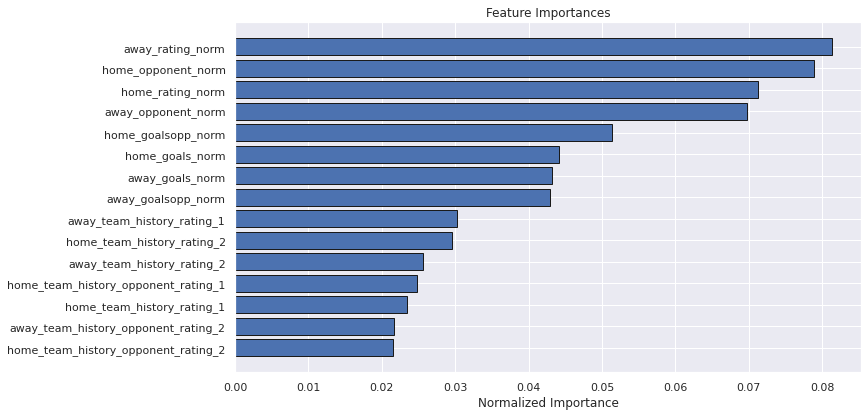

,index,feature,importance,importance_normalized
0,142,away_rating_norm,0.081283,0.081283
1,143,home_opponent_norm,0.078914,0.078914
2,141,home_rating_norm,0.071247,0.071247
3,144,away_opponent_norm,0.069791,0.069791
4,147,home_goalsopp_norm,0.051299,0.051299
...,...,...,...,...
148,4,home_team_history_is_play_home_4,0.000000,0.000000
149,3,home_team_history_is_play_home_3,0.000000,0.000000
150,70,away_team_history_is_play_home_10,0.000000,0.000000
151,71,away_team_history_is_cup_1,0.000000,0.000000


In [119]:
plot_feature_importances(feature_importances)

### BorutaShap

In [86]:
X_train_boruta = train.drop(columns=['id', 'target', 'home_team_name', 'away_team_name', 'league_name'])
y_train_boruta = train['target']

In [89]:
X_train_boruta = X_train_boruta.fillna(X_train_boruta.mean())

In [ ]:
from BorutaShap import BorutaShap

feature_selector = BorutaShap(importance_measure='shap', classification=True)
feature_selector.fit(X_train_boruta, y_train_boruta, n_trials=20, random_state=42)

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
feature_Selector.plot(which_features='all', figsize=(16,12))